# Entropy

Basic idea - I want to see if the neg heads are well-characterised as increasing the entropy of the distribution.

I'm going to try 2 ways of measuring the "marginal entropy" of a head:

1. The difference between entropy of `resid_pre + head_output` and `resid_pre`
2. The difference between entropy of `resid_pre_final` and `resid_pre_final - head_output`

both viewed through the logit lens.

There are 3 main functions in my `entropy.py` file:

* `entropy_measure` returns three tensors: 
    * `resid_entropies` = entropy at different points in the residual stream (logit lens)
    * `entropy_diffs` = entropy difference in residual stream, before and after head contribution (positive = head increases entropy, which is rarer)
    * `entropy_marginals` = entropy difference when head contribution is removed from final logits (positive = head increases entropy, which is rarer)
* `make_entropy_resid_plots` and `make_entropy_plots`, which visualise the first of these objects, and the second/third respectively

In [1]:
from transformer_lens.cautils.notebook import *

model = HookedTransformer.from_pretrained(
    # "solu-10l",
    "gpt2",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
)
model.set_use_split_qkv_input(True)

clear_output()

In [2]:
from transformer_lens.rs.callum.entropy import entropy_measure, make_entropy_plots, make_entropy_resid_plots

clear_output()

NUM_BATCHES = 4
BATCH_SIZE = 8
IOI_BATCH_SIZE = 100

In [3]:
def get_webtext(seed: int = 420, max_length: Optional[int] = None) -> List[str]:
    """Get 10,000 sentences from the OpenWebText dataset"""

    # Let's see some WEBTEXT
    raw_dataset = load_dataset("stas/openwebtext-10k", split="train")

    if max_length is None: max_length = model.cfg.n_ctx
    tokenized_dataset = tokenize_and_concatenate(raw_dataset, model.tokenizer, streaming=False, max_length=max_length, column_name="text", add_bos_token=True, num_proc=4)
    
    dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    
    return dataloader


my_dataloader = get_webtext(max_length=500)

Found cached dataset openwebtext-10k (/home/ubuntu/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-cedab74f9acc3ff5_*_of_00004.arrow


In [4]:
my_dataloader_iter = iter(my_dataloader)

first_batches = [next(my_dataloader_iter)['tokens'] for _ in range(NUM_BATCHES)]

print(first_batches[0].shape)

torch.Size([8, 500])


In [5]:
resid_entropies, entropy_diffs, entropy_marginals = entropy_measure(model, first_batches)

  0%|          | 0/624 [00:00<?, ?it/s]

In [ ]:
make_entropy_resid_plots(resid_entropies, static=True)

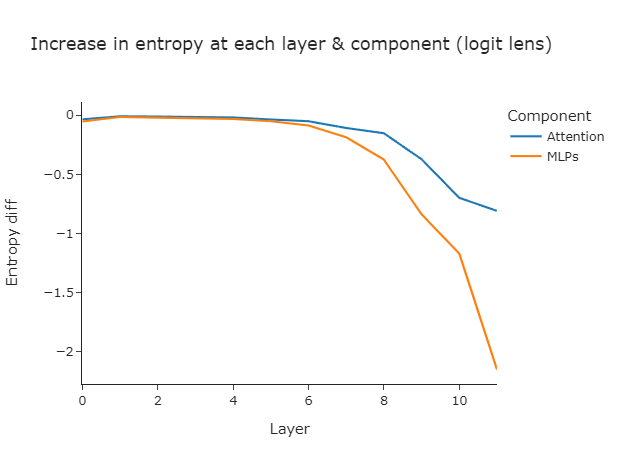

In [14]:
fig_list = make_entropy_plots(entropy_diffs, entropy_marginals, model, title="webtext", static=True)

for fig in fig_list:
    fig.show(config = {'displaylogo': False, 'staticPlot': True})

In [15]:
IOI_BATCH_SIZE = 100

ioi_dataset, abc_dataset, ioi_cache, abc_cache, ioi_metric_noising = generate_data_and_caches(
    N=IOI_BATCH_SIZE,
    model=model,
    verbose=False,
    seed=420,
    prepend_bos=True
)

In [16]:
resid_entropies_ioi, entropy_diffs_ioi, entropy_marginals_ioi = entropy_measure(model, ioi_dataset.toks)

  0%|          | 0/156 [00:00<?, ?it/s]

In [ ]:
make_entropy_resid_plots(resid_entropies_ioi, static=True)

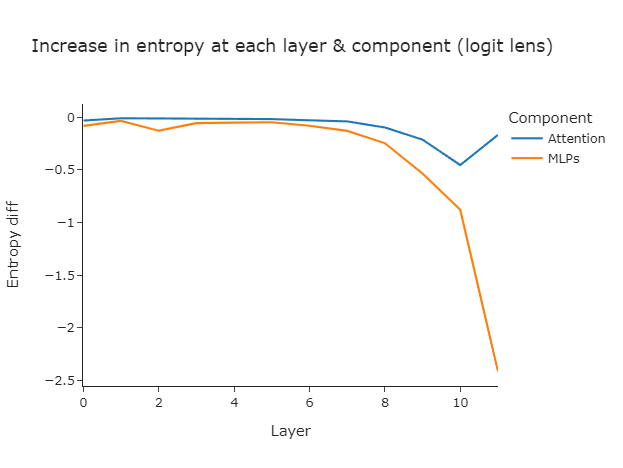

In [26]:
fig_list = make_entropy_plots(entropy_diffs_ioi, entropy_marginals_ioi, model, title="webtext", static=True)

for fig in fig_list:
    fig.show(config = {'displaylogo': False, 'staticPlot': True})

# Analysis so far

Entropy drops a lot from layer 0 to 1, because the MLPs act as an extended embedding.

If we measure diff rather than marginal, then we mainly capture the heads which write stuff to the residual stream. 

No matter how you measure it, heads 11.10 and 10.7 stand out as the main ones which increase entropy.

Key question - are these heads well-described as "entropy-increasing heads", and things like copy-suppression are a consequence of this? Or do these heads implement a bunch of heuristics like copy-suppression, and entropy-increase is a side-effect of this? I think the latter seems more likely.